In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import seaborn as sns
from IPython import display
import numpy as np
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import sacrebleu
import argparse

sns.set_style('darkgrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

# Experiments

The train set is tokenized, dev and test sets should not be tokenized, but maybe we should change it because it hurts the score.

|          Model         | Hyperparameters | chrF score 0-100 (train/dev) | BLEU score 0-100 (train/dev) |
|:----------------------:|:---------------:|:----------:|:----------:|
| Baseline (check GitHub) |  | _ & 33.3| _ & 18.2|
| Seq2Seq with attention | *iters=100000, MAX_LENGTH=10, lr=0.01, hidden_size=256, teacher=0.0, removing accents* | 73.87 & 10.74 | 50.7257 & 0.8088 |
| Seq2Seq with attention | *iters=100000, MAX_LENGTH=10, lr=0.01, hidden_size=256, teacher=0.0, without removing accents* | 76.4588 & 10.7694 | 50.2791 & 0.8877 |
|                        |                 |            |            |
|                        |                 |            |            |
|                        |                 |            |            |
|                        |                 |            |            |

In [2]:
# Restart CUDA
# sudo rmmod nvidia_uvm
# sudo modprobe nvidia_uvm

## Data

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    """
    Removes accents (maybe we shouldn't use it)
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s, unicode=True):
    if unicode:
        s = unicodeToAscii(s.lower().strip())
    else:
        s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def join_langs(file1, file2, final_file):
    """
    Join to files in different langs to reuse the code.
    """
    
    lines1 = open(file1).readlines()
    lines2 = open(file2).readlines()
    
    file = open(final_file, 'w')
    
    for line1, line2 in zip(lines1, lines2):
        line1 = line1.replace('\n', '')
        line2 = line2.replace('\n', '')
        line = line1 + '\t' + line2 + '\n'

        file.write(line)   
        
    file.close()
    print('Finished. # of sentences: {}'.format(len(lines1)))

In [6]:
join_langs('../../data/nahuatl-spanish/train.es', 
           '../../data/nahuatl-spanish/train.nah',
           'data/es-nah.txt')

Finished. # of sentences: 16145


In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
MAX_LENGTH = 20

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(f'Input {input_lang.name} {input_lang.n_words}')
    print(f'Output {output_lang.name} {output_lang.n_words}')
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('es', 'nah', False)
print(random.choice(pairs))

Reading lines...
Read 16145 sentence pairs
Trimmed to 9353 sentence pairs
Counting words...
Counted words:
Input es 7962
Output nah 13784
['lo vinieron a sacar lo mataron .', 'okikistiko kimikti ke .']


## Model

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training

### Preparing the data

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio up to use more of it.

In [14]:
teacher_forcing_ratio = 0.0

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    random.seed(42)
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [15]:
import time
import math

In [16]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

In [17]:
def trainIters(encoder, decoder, n_iters, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_iters = []
    plot_losses = []
    plot_chrf = []
    plot_bleu = []
    plot_chrf_dev = []
    plot_bleu_dev = []
    print_loss_total = 0  # Reset every plot_every
    plot_loss_total = 0   # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in trange(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss          

        if iter % plot_every == 0:               
            print_loss_avg = print_loss_total / plot_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            
            display.clear_output(wait=True)
            
            plot_iters.append(iter)
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
            system_lines = []
            gold_lines = [sentence[1] for sentence in pairs]
            for sentence_es, sentence_nah in pairs:
                output_words, _ = evaluate(encoder1, attn_decoder1, sentence_es)
                output_sentence = ' '.join(output_words[0:-1])
                system_lines.append(output_sentence)
                
            chrf_score = sacrebleu.corpus_chrf(system_lines, [gold_lines]).score
            bleu_score = sacrebleu.corpus_bleu(system_lines, [gold_lines]).score
            plot_chrf.append(100*chrf_score)
            plot_bleu.append(bleu_score)
            
            system_lines = []
            gold_lines = []
            all_input_lines = open('../../data/nahuatl-spanish/dev.es').readlines()
            all_gold_lines = open('../../data/nahuatl-spanish/dev.nah').readlines()
            
            for i, (input_sentence, nah_sentence) in enumerate(zip(all_input_lines, all_gold_lines)):
                input_sentence = normalizeString(input_sentence)
                try:
                    output_words, _ = evaluate(encoder1, attn_decoder1, input_sentence)
                    output_sentence = ' '.join(output_words[0:-1])

                    system_lines.append(output_sentence)
                    gold_lines.append(nah_sentence)
                except:
                    pass   
                
            chrf_score_dev = sacrebleu.corpus_chrf(system_lines, [gold_lines]).score
            bleu_score_dev = sacrebleu.corpus_bleu(system_lines, [gold_lines]).score
            plot_chrf_dev.append(100*chrf_score_dev)
            plot_bleu_dev.append(bleu_score_dev)
            
            showPlot(plot_iters, plot_losses, plot_chrf, plot_bleu, plot_chrf_dev, plot_bleu_dev)
    
    print('%s (%d %d%%) %.4f \n' % (timeSince(start, iter / n_iters),
                                    iter, iter / n_iters * 100, print_loss_avg))       
    
    print('### BEST SCORES ###')
    print(f'chrF2 train = {round(np.max(plot_chrf), 4)}')
    print(f'chrF2 dev = {round(np.max(plot_chrf_dev), 4)}')
    print(f'BLEU train = {round(np.max(plot_bleu), 4)}')
    print(f'BLEU dev = {round(np.max(plot_bleu_dev), 4)}')

In [18]:
def showPlot(plot_iters, plot_losses, plot_chrf, plot_bleu, plot_chrf_dev, plot_bleu_dev):
    plt.figure()
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
    # this locator puts ticks at regular intervals
    # loc = ticker.MultipleLocator(base=0.2)
    # ax.yaxis.set_major_locator(loc)
    # plt.plot(points)
    
    ax0.plot(plot_iters, plot_losses, marker='o')
    ax0.set_title('Loss')
    ax0.set_xlabel('Iters')
    ax0.set_ylabel('Loss')
    ax0.legend()
    
    ax1.plot(plot_iters, plot_chrf, marker='o', label='Train')
    ax1.plot(plot_iters, plot_chrf_dev, marker='o', label='Dev')
    ax1.set_title('chrF score')
    ax1.set_xlabel('Iters')
    ax1.set_ylabel('chrF score')
    ax1.legend()
    
    ax2.plot(plot_iters, plot_bleu, marker='o', label='Train')
    ax2.plot(plot_iters, plot_bleu_dev, marker='o', label='Dev')
    ax2.set_title('BLEU score.')
    ax2.set_xlabel('Iters')
    ax2.set_ylabel('BLEU score')
    ax2.legend()
    
    plt.show()

## Evaluation

In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating

In [21]:
output_lang.n_words, input_lang.n_words

(13784, 7962)

100%|█████████▉| 99995/100000 [44:20<00:00, 53.74it/s]That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

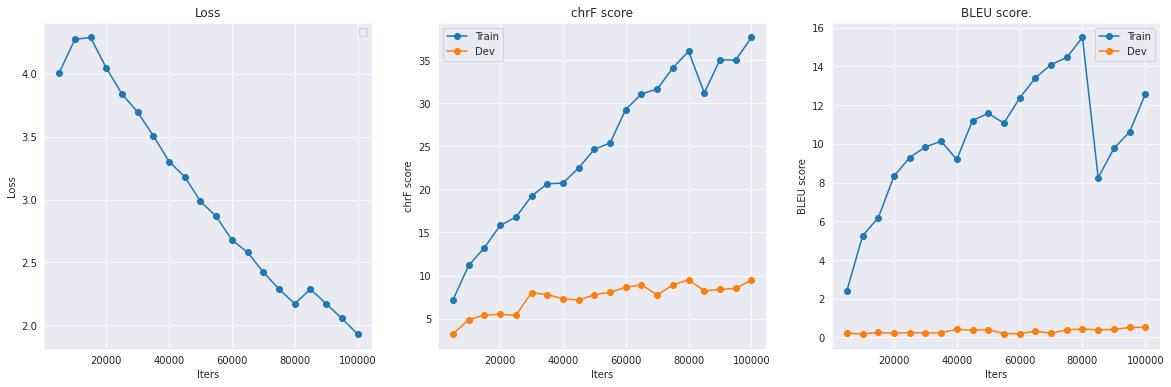

100%|██████████| 100000/100000 [44:48<00:00, 37.19it/s]

44m 53s (- 0m 0s) (100000 100%) 1.9297 

### BEST SCORES ###
chrF2 train = 37.6671
chrF2 dev = 9.5021
BLEU train = 15.4871
BLEU dev = 0.5244


In [22]:
torch.manual_seed(42)

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 100000, plot_every=5000)

In [23]:
evaluateRandomly(encoder1, attn_decoder1)

> cada hombre tiene tus preocupaciones .
= cocentlacatl quinpiah iyoltspacholtin .
< cocentlacatl cocentlacatl iyoltspacholtin . . <EOS>

> el mas justo
= in ocachi cualyotica
< in ocachi cualyotica <EOS>

> dana mucho a nuestro cuerpo .
= tlauel techtlakasolo
< tlauel . . <EOS>

> si senor .
= auhtzin tlahtoane !
< quemahcatzin . . <EOS>

> estos fueron los hijos a quienes tezozomoctzin puso a gobernar en varios pueblos .
= yzquintin hi ympilhua tecocomocci yn quimoyauh nouian altepetlipa .
< yn hi hi yn yn yn ca yn unca yn <EOS>

> crujiente
= kikuajtika
< kikuajtika <EOS>

> alli aparecio el maiz dicen
= noponi monextik sintli kiijtouaj
< noponi kiijtouaj kiijtouaj <EOS>

> alli voy a llamarlo .
= ompa nicnotzati .
< ompa nicnotzati . <EOS>

> este ano es construida la catedral de mexico .
= ipan inin xihuitl chihualo huei iteocaltzin mexico .
< ipan inin xihuitl huei huei huei mexico . <EOS>

> nosotros hicimos un viaje a la proxima ciudad .
= tehuan otiahqueh in nechca altepetl .


In [24]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
#     showAttention(input_sentence, output_words, attentions)

Let's try with some of the sentences in the train dataset.

In [25]:
input_sentence = 'vete a casa te buscan'
gold_reference = 'todian xia mitztemoa'
output_words, _ = evaluate(encoder1, attn_decoder1, input_sentence)

print(f'Input: {input_sentence}')
print(f'Gold: {gold_reference}')
print(f'Output: {" ".join(output_words)}')

Input: vete a casa te buscan
Gold: todian xia mitztemoa
Output: tehhua nehon <EOS>


Let's try with some of the sentences in the dev dataset.

In [26]:
input_sentence = 'ella siguio hablando'
gold_reference = 'ya quicencuilihqui tlahtoa'
output_words, _ = evaluate(encoder1, attn_decoder1, input_sentence)

print(f'Input: {input_sentence}')
print(f'Gold: {gold_reference}')
print(f'Output: {" ".join(output_words)}')

Input: ella siguio hablando
Gold: ya quicencuilihqui tlahtoa
Output: in in <EOS>


In [27]:
input_sentence = 'no tengo mucho dinero en este momento'
gold_reference = 'Naman axnicpiya tomintzin.'
output_words, _ = evaluate(encoder1, attn_decoder1, input_sentence)

print(f'Input: {input_sentence}')
print(f'Gold: {gold_reference}')
print(f'Output: {" ".join(output_words)}')

Input: no tengo mucho dinero en este momento
Gold: Naman axnicpiya tomintzin.
Output: man amo itech itech <EOS>


In [28]:
def calculate_score_report(sys, ref, score_only):

    chrf = sacrebleu.corpus_chrf(sys, ref)
    bleu = sacrebleu.corpus_bleu(sys, ref)

    prefix = 'BLEU = ' if score_only else ''

    print('#### Score Report ####')
    print(chrf)
    print('{}{}'.format(prefix, bleu.format(score_only=score_only)))

In [29]:
system_lines = []
gold_lines = []
all_input_lines = open('../../data/nahuatl-spanish/dev.es').readlines()
all_gold_lines = open('../../data/nahuatl-spanish/dev.nah').readlines()

for i, (input_sentence, nah_sentence) in enumerate(zip(all_input_lines, all_gold_lines)):
    input_sentence = normalizeString(input_sentence)
    try:
        output_words, _ = evaluate(encoder1, attn_decoder1, input_sentence)
        output_sentence = ' '.join(output_words[0:-1])
        
        system_lines.append(output_sentence)
        gold_lines.append(nah_sentence)
    except:
        pass   

In [30]:
for sys, gold in zip(system_lines, gold_lines):
    print(f'System: {sys}')
    print(f'Gold: {gold}')

System: mah amo tlen queman . .
Gold: Nicchia inin problema mitzmaca yancuic entusiasmo 

System: nochi nochi in calli . .
Gold: tiquilihqueh nochin tlen nihin tequitl

System: in man amo maria . .
Gold: Niccactoc axcualli. 

System: tein tein itech yn tein tein .
Gold: Nineltoca ihcuac tlacameh miquzqueh , mocupepazqueh quenin yolcameh

System: moztla ni moztla man .
Gold: nicchiuhtoc tlen nechcahuilihqueh mah nicchihua yehua cualcan

System:  nanmociwili de de
Gold: ¿ticnequizquia miyac tlamantli tlacualli?

System: in kemej ya pero .
Gold: ihueltiuh in cihtli ixchipahuac catca

System: mah amo queman queman . .
Gold: nicmatoc yehhua amo mitziliz

System: in zan
Gold: Ya quicencuilihqui tlahtoa.

System: asta nehon ica . .
Gold: zan nicpiya $20 itlamiyan queman tlaxtlahuaceh.

System: ce xochitl ce hueyi ce
Gold: Axqueman nicpiyaz ce V6.

System: asan amo a pajti asan pero .
Gold: cualli, amo acah yetoc onpa tlen hueliz nechpalehuizqueh 

System: in tonatiuh yn in yn .
Gold: quemania

In [31]:
def calculate_score_report(sys, ref, score_only):

    chrf = sacrebleu.corpus_chrf(sys, ref)
    bleu = sacrebleu.corpus_bleu(sys, ref)

    prefix = 'BLEU = ' if score_only else ''

    print('#### Score Report ####')
    print(chrf)
    print('{}{}'.format(prefix, bleu.format(score_only=score_only)))

In [32]:
sacrebleu.corpus_chrf(['hola'], [['hola']])

chrF2 = 1.000

It is really bad.

In [33]:
calculate_score_report(system_lines, [gold_lines], score_only=True)

#### Score Report ####
chrF2 = 0.092
BLEU = 0.48


In [34]:
print(f'chrF2 score = {sacrebleu.corpus_chrf(system_lines, [gold_lines]).score}')
print(f'BLEU score = {sacrebleu.corpus_bleu(system_lines, [gold_lines]).score}')

chrF2 score = 0.09234680377397508
BLEU score = 0.4759103816868762
